In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append("../")
import itertools as it
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

if sys.platform == 'darwin':
    print("Detected MacOS, defaulting to CPU")
    tf.config.set_visible_devices([], "GPU")
gpu_devices = tf.config.list_logical_devices("GPU")
cpu_devices = tf.config.list_logical_devices("CPU")
number_of_available_gpus = len(gpu_devices)
number_of_available_cpus = len(cpu_devices)
if number_of_available_gpus > 0:
    print("Using GPU(s)")
    devices = gpu_devices
else:
    print("Using CPU(s)")
    devices = cpu_devices
strategy = tf.distribute.OneDeviceStrategy(devices[0].name)

from utils import data_saver, get_train_method

Detected MacOS, defaulting to CPU
Using CPU(s)


In [3]:
def movingaverage(values, window):
    weights = np.repeat(1.0, window) / window
    sma = np.convolve(values, weights, 'valid')
    return sma

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 15,
    "font.family": "Helvetica"
})

bigger_font_size=22
column_width = 3.75
square_fig_size=(2*column_width,3/2*column_width)


# Code to get data

In [41]:
def get_data(MS, bc):
    units = 256
    na = 10000
    Lx, Ly = 6,6
    lattice = 'Triangular'
    N_spins = Lx*Ly
    data_path_prepend = '../..'
    T0 = 0.0
    scale = 4.0
    rate = 0.25
    if bc=='periodic':
        T0_L_6 = 1.0
        runs = {
            'No Phase Avg.': {'boundary_condition': 'periodic', 'Apply_MS':True, 'h_symmetries':True, 
                                 'l_symmetries':True, 'experiment_name':'Apr4NoPhaseAvg', 'weight_sharing':'all', 
                                  'which_MS':MS, 'scale':scale, 'rate':rate, "T0_L_6":T0_L_6},
            'Phase Avg.': {'boundary_condition': 'periodic', 'Apply_MS':True, 'h_symmetries':True, 
                                   'l_symmetries':True, 'experiment_name':'Apr4PhaseAvgC6v', 'weight_sharing':'all', 
                                   'which_MS':MS, 'scale':scale, 'rate':rate, "T0_L_6":T0_L_6},
           }
    energies = {}
    for run_name, config_data in runs.items():
        config = {
                # Seeding for reproducibility purposes
                'seed': 100,
                'tf_dtype': tf.float32,
                #### System
                'Hamiltonian': 'AFHeisenberg',
                'Lattice': lattice,
                'Nx': Lx,  # number of sites in x-direction
                'Ny': Ly,  # number of sites in the y-direction
                'units':units,
                ### RNN
                'activation_function': tf.nn.tanh,  # activation of the RNN cell
                'num_samples': 100,
                #### Annealing
                'Tmax': 0.,  # Highest temperature, if Tmax=0 then its VMC, ***add if statement to skip annealing if Tmax = 0
                'num_warmup_steps': 1000,  # number of warmup steps 1000 = default (also shouldn't be relevant if Tmax = 0)
                'num_annealing_steps': 10000,  # number of annealing steps
                'num_equilibrium_steps': 5,  # number of gradient steps at each temperature value
                'num_training_steps': 0,  # number of training steps
                #### Symmetries
                'l_symmetries': True,
                'spin_parity': False,
                ### OTHER
                'data_path_prepend': data_path_prepend,
                'CKPT': True,  # whether to save the model during training
                'WRITE': False,  # whether to save training data to file
                'PRINT': False,  # whether to print progress throughout training
                'PLOT': False,  # whether to plot after training
                'TRAIN': False,  # whether to train the model
            }
        for k,v in config_data.items():
            config[k] = v
        train_method = get_train_method(T0, config['h_symmetries'], config['l_symmetries'])
        save_path = data_saver(config, train_method, N_spins, data_path_prepend=data_path_prepend)
        try:
            energies[run_name] = np.load(save_path + '/RE_meanEnergy.npy')
        except FileNotFoundError:
            print('not found')
            print(run_name)
            print(save_path)
            energies[run_name] =[np.nan]
    return runs, energies

# Triangular MS

In [73]:
runs_periodic_tri, energies_periodic_tri = get_data("Triangular", "periodic")

colors_periodic = dict(zip(runs_periodic_tri.keys(), [plt.get_cmap('Reds'), plt.get_cmap('Greens'), plt.get_cmap('Blues')]))

## Periodic

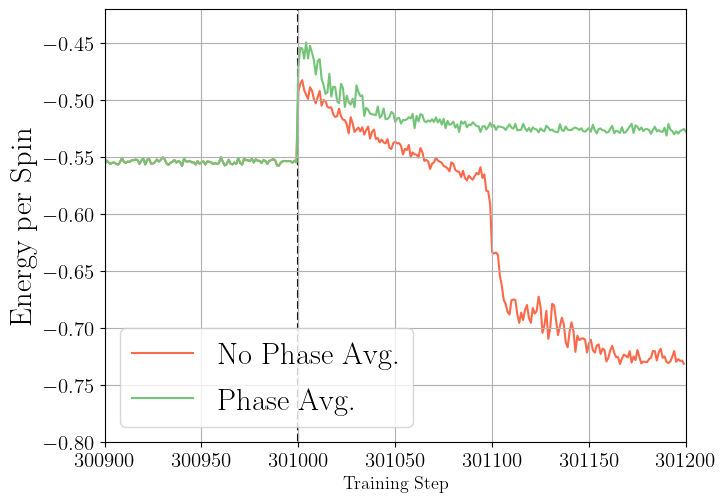

In [74]:
Lx,Ly=6,6
N_spins = Lx*Ly
plt.figure(figsize=square_fig_size)
largest_xe = 0
grey = plt.get_cmap('Greys')
for run_name, en, in energies_periodic_tri.items():
    # e = np.array(movingaverage(en,100)) / (Lx*Ly)
    e = np.array(en) / (Lx*Ly)
    xe = np.arange(len(e))
    if max(xe)>largest_xe:
        largest_xe = max(xe)
    plt.plot(xe, e, label = rf'{run_name}',zorder=0, color=colors_periodic[run_name](0.5))  

plt.vlines(301000, -34/ N_spins, -1 / N_spins, color=grey(0.95), linestyles='--', zorder=-1)    

plt.legend(loc='lower left',fontsize=bigger_font_size)
plt.ylabel('Energy per Spin',fontsize=bigger_font_size)
plt.ylim([-0.8,-0.42])
plt.xlim([300900,301200])
plt.grid()
plt.xlabel('Training Step',fontsize=13)
plt.savefig("./final_figures/energies.pdf")
plt.show()

# Plot phases

## Code

In [44]:
import glob
import re
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase
import matplotlib as mpl

In [45]:
def get_data_phases(run):
    phase_data = {}
    log_probs_data = {}

    for run_name, config_data in run.items():
        units = 256
        na = 10000
        Lx, Ly = 6,6
        lattice = 'Triangular'
        N_spins = Lx*Ly
        data_path_prepend = '../..'
        T0 = 0.0
        scale = 4.0
        rate = 0.25
        config = {
                    # Seeding for reproducibility purposes
                    'seed': 100,
                    'tf_dtype': tf.float32,
                    #### System
                    'Hamiltonian': 'AFHeisenberg',
                    'Flavor': 'AF',
                    'Lattice': lattice,
                    'Nx': Lx,  # number of sites in x-direction
                    'Ny': Ly,  # number of sites in the y-direction
                    'units':units,
                    ### RNN
                    'activation_function': tf.nn.tanh,  # activation of the RNN cell
                    'num_samples': 100,
                    #### Annealing
                    'Tmax': 0.,  # Highest temperature, if Tmax=0 then its VMC, ***add if statement to skip annealing if Tmax = 0
                    'num_warmup_steps': 1000,  # number of warmup steps 1000 = default (also shouldn't be relevant if Tmax = 0)
                    'num_annealing_steps': 10000,  # number of annealing steps
                    'num_equilibrium_steps': 5,  # number of gradient steps at each temperature value
                    'num_training_steps': 0,  # number of training steps
                    #### Symmetries
                    'l_symmetries': True,
                    'spin_parity': False,
                    ### OTHER
                    'data_path_prepend': data_path_prepend,
                    'CKPT': True,  # whether to save the model during training
                    'WRITE': False,  # whether to save training data to file
                    'PRINT': False,  # whether to print progress throughout training
                    'PLOT': False,  # whether to plot after training
                    'TRAIN': False,  # whether to train the model
                }
        for k,v in config_data.items():
            config[k] = v
        train_method = get_train_method(T0, config['h_symmetries'], config['l_symmetries'])
        save_path = data_saver(config, train_method, N_spins, data_path_prepend=data_path_prepend)
        
        
        # List all matching files
        files = glob.glob(save_path+"/*_expphases.npy")

        # Sort the files numerically based on the integer prefix
        files_sorted_phases = sorted(files, key=lambda x: int(re.search(r"(\d+)_expphases.npy", os.path.basename(x)).group(1)))
        files = glob.glob(save_path+"/*_logprobs.npy")
        files_sorted_logprobs = sorted(files, key=lambda x: int(re.search(r"(\d+)_logprobs.npy", os.path.basename(x)).group(1)))
        phases = []
        for file in files_sorted_phases:
            name = os.path.basename(file)
            step = int(name.split("_")[0])
            phases.append([step, np.load(file)])
        phase_data[run_name] = phases.copy()
        logprobs = []
        for file in files_sorted_logprobs:
            name = os.path.basename(file)
            step = int(name.split("_")[0])
            logprobs.append([step, np.load(file)])
        log_probs_data[run_name] = logprobs.copy()
    return phase_data, log_probs_data

In [46]:
import scipy
def regularized_identity(inputs, epsilon=1e-5):
    """
    Apply the regularized identity to a certain input.

    Args:
        inputs: A Tensor of any shape.
        epsilon: Regularization constant to make sure the square root is not negative. Default is 1e-5.

    Returns:
        A regularized tensor.
    """
    sign = np.sign(np.sign(inputs) + 0.1)  # tf.sign(0) = 0, this is a way to cure that since I want tf.sign(0) = 1
    return sign +  np.sqrt(inputs ** 2 + epsilon ** 2)
    
def phase_average(exp_phases):
    # real_avg = regularized_identity(np.real(np.sum(exp_phases, axis=0)))
    real_avg = np.real(np.sum(exp_phases, axis=0))
    imag_avg = np.imag(np.sum(exp_phases, axis=0))
    return real_avg+ 1j*imag_avg

def amplitude_average(log_probs):
    num_symmetries = log_probs.shape[0]
    log_num_symmetries = np.log(num_symmetries)
    return scipy.special.logsumexp(log_probs - log_num_symmetries, axis=0)
    

In [121]:
def polar_plot(_data, name, step, axs, legend, cmap, nsamples=10):
    if not _data:
        print("No data found")
        return
    cmin = 0.2
    nsym = _data[step][1].shape[0]
    cvalues = np.linspace(cmin, 1, nsym)
    colors_rot = [cmap(0.5), cmap(1.)]
    labels = [r"$k\times120^\circ$", r"$60^\circ+k\times120^\circ$"]
    for i in range(nsamples):
        omega = _data[step][1][:, i]
        r = i+1
        omega = r*(np.cos(omega) + 1j*np.sin(omega))
        for k in range(nsym):
            plot = axs.plot(np.angle(omega[k]), np.abs(omega[k]), marker='.', linestyle='',markersize='10', color=colors_rot[k%2])
        omega_avg = phase_average(omega)
        axs.plot(np.angle(omega_avg), np.abs(omega[0]), marker='x', linestyle='',markersize='7', color='black')
        axs.set_title(f"{name}")
    if legend:
        legend_elements = [mpl.lines.Line2D([0], [0], color=colors_rot[k%2], lw=2,
                                            label=labels[int(k%2)]) for k in range(2)]
        axs.legend(handles=legend_elements,  bbox_to_anchor=(1., 1.06))
    axs.set_rmax(1.3)
    axs.set_aspect('equal')
    # axs.set_rticks(list(range(1,11)))
    axs.set_rlim(0,nsamples+2)
    

def polar_plot_result_only_avg(_data, name, step, axs, legend, cmap, nsamples=100):
    if not _data:
        print("No data found")
        return
    cmin = 0.2
    nsym = _data[step][1].shape[0]
    cvalues = np.linspace(cmin, 1, nsym)
    colors_rot = [cmap(0.5), cmap(1.)]
    labels = [r"$k\times120^\circ$", r"$60^\circ+k\times120^\circ$"]
    for i in range(nsamples):
        omega = _data[step][1][:, i]
        r = i+1
        omega = r*(np.cos(omega) + 1j*np.sin(omega))
        # plot = axs.plot(np.angle(omega[k]), np.abs(omega[k]), marker='.', linestyle='',markersize='10', color=colors_rot[k%2])
        omega_avg = phase_average(omega)
        axs.plot(np.angle(omega_avg), np.abs(omega[0]), marker='x', linestyle='',markersize='7', color=colors_rot[0])
        axs.set_title(f"{name}")
    if legend:
        legend_elements = [mpl.lines.Line2D([0], [0], color=colors_rot[0], lw=2,   label="Averaged Phase")]
        axs.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1.06))
    axs.set_rmax(1.3)
    # axs.set_rticks(list(range(1,11)))
    axs.set_aspect('equal')

    axs.set_rlim(0,nsamples+2)

def polar_plot_result_only(_data, name, step, axs, legend, cmap, nsamples=100):
    if not _data:
        print("No data found")
        return
    cmin = 0.2
    nsym = _data[step][1].shape[0]
    cvalues = np.linspace(cmin, 1, nsym)
    colors_rot = [cmap(0.5), cmap(1.)]
    labels = [r"$k\times120^\circ$", r"$60^\circ+k\times120^\circ$"]
    for i in range(nsamples):
        omega = _data[step][1][:, i]
        r = i+1
        omega = r*(np.cos(omega) + 1j*np.sin(omega))
        plot = axs.plot(np.angle(omega[0]), np.abs(omega[0]), marker='.', linestyle='',markersize='10', color=colors_rot[0])
        # omega_avg = phase_average(omega)
        # axs.plot(np.angle(omega_avg), np.abs(omega[0]), marker='x', linestyle='',markersize='7', color='black')
        axs.set_title(f"{name}")
    if legend:
        legend_elements = [mpl.lines.Line2D([0], [0], color=colors_rot[0], lw=2, label="Phase")]
        axs.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1.06))
    axs.set_rmax(1.3)
    axs.set_aspect('equal')
    # axs.set_rticks(list(range(1,11)))
    axs.set_rlim(0,nsamples+2)

In [122]:
def amplitude_plot(_data, sym, step):
    if sym=='C6v':
        rot_names = {0: "Id",1: "Rot60" , 2:"Rot120", 3:"Rot180", 4:"Rot240",5:"Rot300",
                     6: "Flip", 7: "FlipRot60" , 8:"FlipRot120", 9:"FlipRot180", 10:"FlipRot240",11:"FlipRot300"}

    if not _data:
        print("No data found")
        return
    fig, axs = plt.subplots(1, 1)
    fig.set_size_inches(square_fig_size)

    nsamples = 100
    cmap = plt.get_cmap('Set2')
    cmin = 0.2
    nsym = _data[step][1].shape[0]
    cvalues = np.linspace(cmin, 1, nsym)
    colors= ['xkcd:fire engine red', 'xkcd:golden yellow', 'xkcd:electric blue', 'xkcd:neon green', 
             'xkcd:hot pink', 'xkcd:deep purple', 'xkcd:cyan', 'xkcd:lime', 'xkcd:orange', 'xkcd:black', "xkcd:turquoise",
             "xkcd:bright violet"]
    colors_rot = ['xkcd:fire engine red', 'xkcd:electric blue']
    labels = [r"$k\times120^\circ$", r"$60^\circ+k\times120^\circ$"]
    logp = _data[step][1]
    logp_avg = amplitude_average(logp)
    for i in range(nsamples):
        for k in range(nsym):
            plot = axs.plot(i, logp[k,i], marker='.', linestyle='',markersize='10', color=colors_rot[k%2])
        axs.plot(i, logp_avg[i], marker='x', linestyle='',markersize='7', color='black')
        axs.set_title(f"Step {step}")
    
    axs.grid()
    legend_elements = [mpl.lines.Line2D([0], [0], color=colors_rot[k%2], lw=2,
                                        label=labels[int(k%2)]) for k in range(2)]
    axs.legend(handles=legend_elements)
    axs.set_ylabel(r"$\log p$", fontsize=bigger_font_size)
    axs.set_xlabel(r"Sample",fontsize=bigger_font_size)
    # axs.set_rmax(1.3)
    # axs.set_rticks(list(range(1,11)))
    axs.set_ylim(-10, -30)
    plt.show()

## Triangular MS, Periodic

In [123]:
runs_periodic_tri = {
            'No Phase Avg.': {'boundary_condition': 'periodic', 'Apply_MS':True, 'h_symmetries':True, 
                                 'l_symmetries':True, 'experiment_name':'Apr4NoPhaseAvg', 'weight_sharing':'all', 
                                  'which_MS':"Triangular", 'scale':4., 'rate':0.25, "T0_L_6":1.},
            'Phase Avg.': {'boundary_condition': 'periodic', 'Apply_MS':True, 'h_symmetries':True, 
                                   'l_symmetries':True, 'experiment_name':'Apr4PhaseAvgC6v', 'weight_sharing':'all', 
                                   'which_MS':"Triangular", 'scale':4., 'rate':0.25, "T0_L_6":1.},
           }

In [124]:
phase_data, log_probs_data = get_data_phases(runs_periodic_tri)

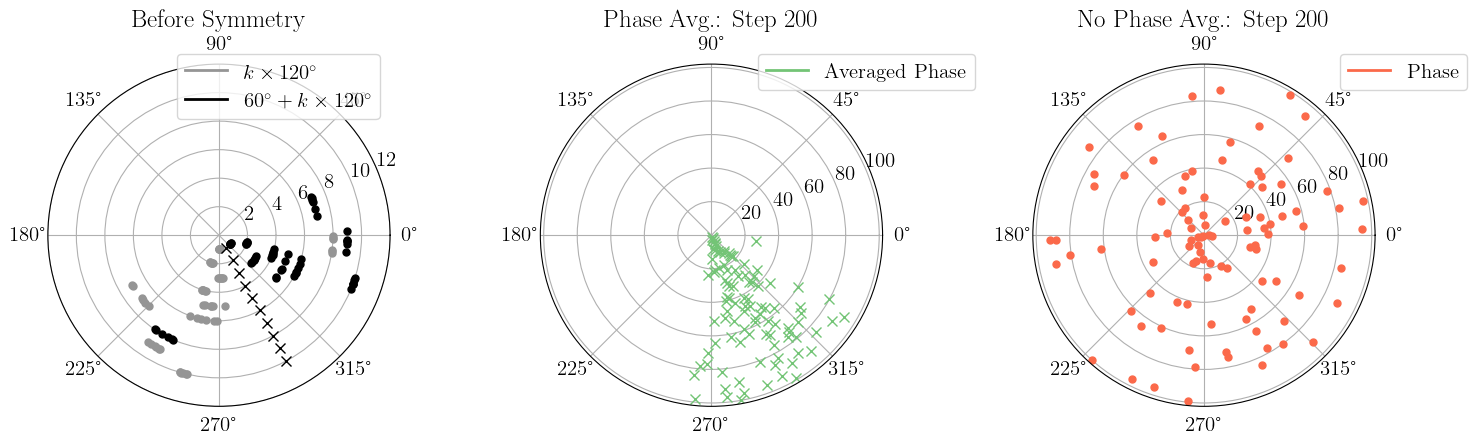

In [127]:

fig, axs = plt.subplots(1,3, subplot_kw={'projection': 'polar'})
fig.set_size_inches(15,7)
name = "Phase Avg."
step = 200
polar_plot(phase_data[name], "Before Symmetry", step=0, axs=axs[0], legend=True, cmap=plt.get_cmap('Greys'))
polar_plot_result_only_avg(phase_data[name], f"{name}: Step {step}", step=step, axs=axs[1], legend=True, cmap=colors_periodic[name])
name = "No Phase Avg."
polar_plot_result_only(phase_data[name], f"{name}: Step {step}", step=step, axs=axs[2], legend=True, cmap=colors_periodic[name])
fig.savefig("./final_figures/phase_average_c6v.pdf")
# plt.tight_layout()
plt.show()

In [76]:
run_final= {'No Phase Avg. Final': {'boundary_condition': 'periodic', 'Apply_MS':True, 'h_symmetries':True, 
                                    'l_symmetries':True, 'experiment_name':'Apr4NoPhaseAvgFinal', 'weight_sharing':'all', 
                                    'which_MS':"Triangular", 'scale':4.0, 'rate':0.25, "T0_L_6":1.}}
phase_data, log_probs_data = get_data_phases(run_final)

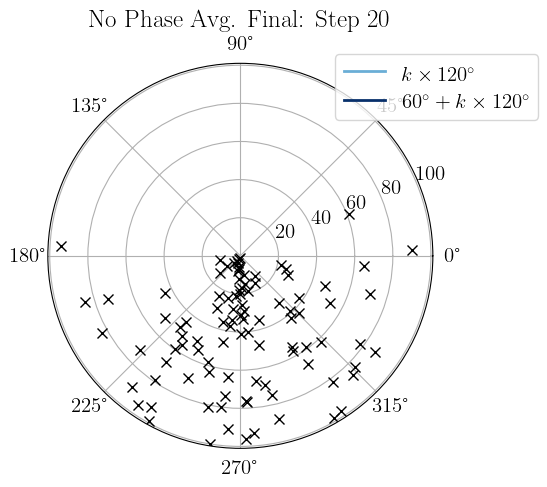

In [79]:
def average_polar_plot(_data, name, step, axs, legend, cmap):
    if not _data:
        print("No data found")
        return
    nsamples = 100
    cmin = 0.2
    nsym = _data[step][1].shape[0]
    cvalues = np.linspace(cmin, 1, nsym)
    colors_rot = [cmap(0.5), cmap(1.)]
    labels = [r"$k\times120^\circ$", r"$60^\circ+k\times120^\circ$"]
    for i in range(nsamples):
        omega = _data[step][1][:, i]
        r = i+1
        omega = r*(np.cos(omega) + 1j*np.sin(omega))
        omega_avg = phase_average(omega)
        axs.plot(np.angle(omega[0]), np.abs(omega[0]), marker='x', linestyle='',markersize='7', color='black')
        axs.set_title(f"{name}")
    if legend:
        legend_elements = [mpl.lines.Line2D([0], [0], color=colors_rot[k%2], lw=2,
                                            label=labels[int(k%2)]) for k in range(2)]
        axs.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1.05))
    # axs.set_rmax(1.3)
    # axs.set_rticks(list(range(1,nsamples+1)))
    axs.set_rlim(0,nsamples+1)

fig, axs = plt.subplots(1,1, subplot_kw={'projection': 'polar'})
fig.set_size_inches(5,5)
name = "No Phase Avg. Final"
step = 20
# average_polar_plot(phase_data[name], f"{name}: Step {step}", step=step, axs=axs, legend=True, cmap=plt.get_cmap("Blues"))
average_polar_plot(phase_data[name], f"{name}: Step {step}", step=step, axs=axs, legend=True, cmap=plt.get_cmap("Blues"))
fig.savefig("./final_figures/phase_averaging_final.pdf")

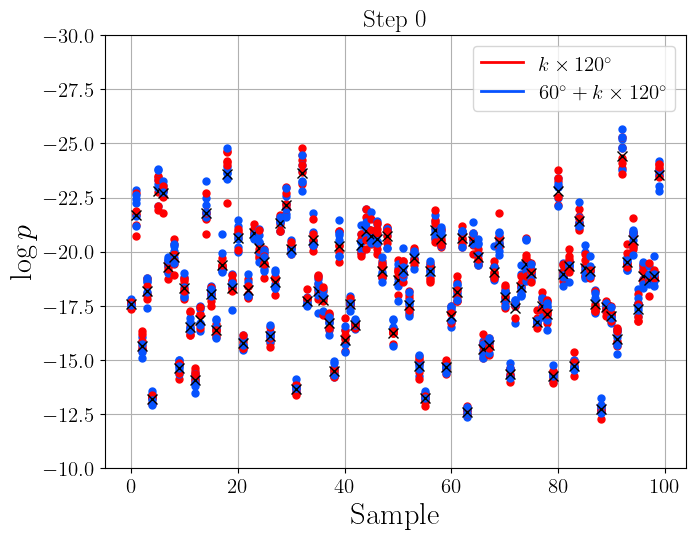

In [54]:
amplitude_plot(log_probs_data["No Phase Avg. Final"], "C6v", step=0)